# Assignment 2

### Load and prepare the data

In [79]:
import tensorflow_datasets as tfds
import tensorflow as tf

dataset = tfds.load('penguins/raw', split='train')

# Filter species to include only Gentoo and Chinstrap penguins
def filter_species(features):
    return features['Species'] != 'Adelie Penguin (Pygoscelis adeliae)'

dataset = dataset.filter(filter_species)

# Process the features for training
def process_features(features):
    new_features = {
        'features': {
            'island': tf.cast(features['Island'] == 'Biscoe', tf.int32),
            'culmen_length': features['Culmen Length (mm)'],
            'culmen_depth': features['Culmen Depth (mm)'],
            'flipper_length': features['Flipper Length (mm)'],
            'body_mass': features['Body Mass (g)'],
            'sex': tf.cast(features['Sex'] == 'MALE', tf.int32)
        },
        'species': tf.cast(features['Species'] == 'Gentoo penguin (Pygoscelis papua)', tf.int32) # 1 if Gentoo, 0 if Chinstrap
    }
    return new_features

dataset = dataset.map(process_features)

def remove_nan(features):
    features = features['features']
    return not (tf.math.is_nan(features['culmen_length']) 
                or tf.math.is_nan(features['culmen_depth']) 
                or tf.math.is_nan(features['flipper_length']) 
                or tf.math.is_nan(features['body_mass']))

dataset = dataset.filter(remove_nan).shuffle(200)

print('Number of examples:', len(list(dataset)))

# Split the dataset into training and testing
train_dataset = dataset.take(153)
test_dataset = dataset.skip(153)

print('Number of training examples:', len(list(train_dataset)))
print('Number of testing examples:', len(list(test_dataset)))

Number of examples: 191
Number of training examples: 153
Number of testing examples: 38


### Evaluate based on Accurace and AUC

In [80]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

x_train = np.array([list(example['features'].values()) for example in train_dataset])
y_train = np.array([example['species'] for example in train_dataset])
x_test = np.array([list(example['features'].values()) for example in test_dataset])
y_test = np.array([example['species'] for example in test_dataset])

print(x_test.shape)
print(y_test.shape)

gaussian = GaussianNB()
logistic = LogisticRegression(max_iter=1000)

gaussian.fit(x_train, y_train)
logistic.fit(x_train, y_train)

(38, 6)
(38,)


LogisticRegression(max_iter=1000)

### Predict and compare

In [81]:
y_pred_gaussian = gaussian.predict(x_test)
y_pred_logistic = logistic.predict(x_test)

print('Gaussian Naive Bayes accuracy:', accuracy_score(y_test, y_pred_gaussian))
print('Logistic Regression accuracy:', accuracy_score(y_test, y_pred_logistic))

gaussian_probs = gaussian.predict_proba(x_test)
logistic_probs = logistic.predict_proba(x_test)


print('Gaussian Naive Bayes AUC:', roc_auc_score(y_test, gaussian_probs[:, 1]))
print('Logistic Regression AUC:', roc_auc_score(y_test, logistic_probs[:, 1]))

Gaussian Naive Bayes accuracy: 0.6578947368421053
Logistic Regression accuracy: 0.6052631578947368
Gaussian Naive Bayes AUC: 0.6398809523809524
Logistic Regression AUC: 0.5446428571428572


### Lift and Gain charts

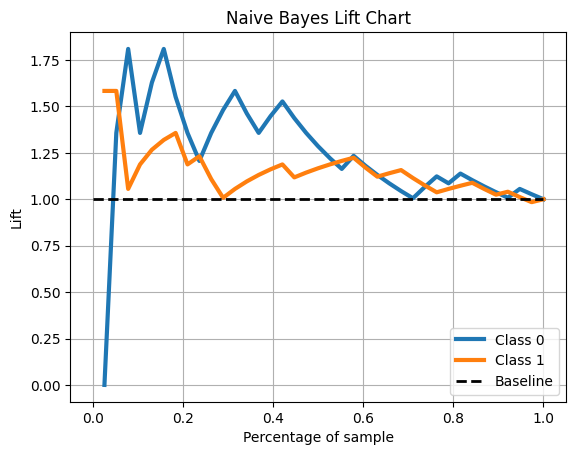

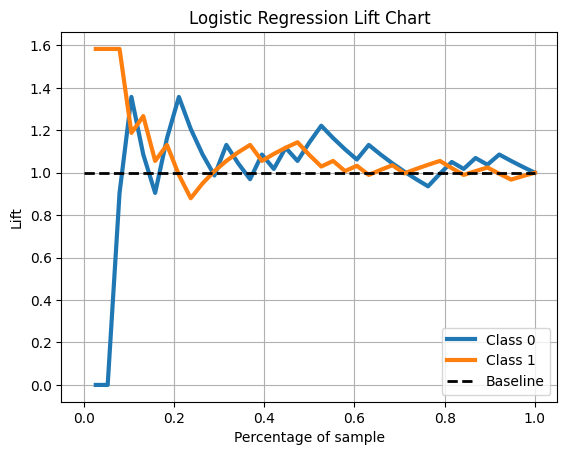

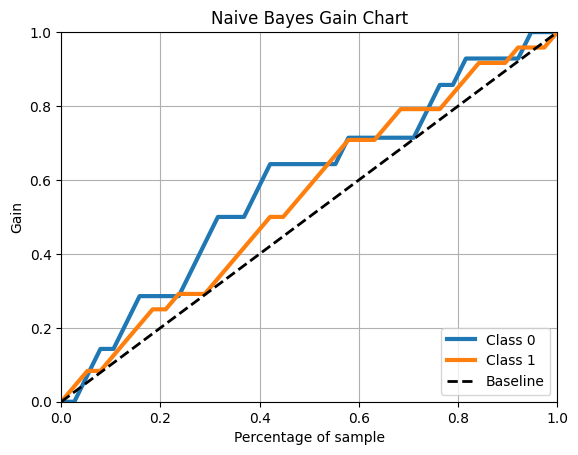

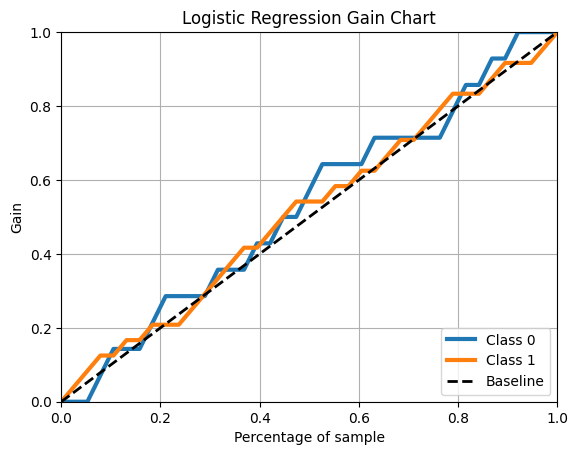

In [82]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_lift_curve(y_test, gaussian_probs, title='Naive Bayes Lift Chart')
plt.show()

skplt.metrics.plot_lift_curve(y_test, logistic_probs, title='Logistic Regression Lift Chart')
plt.show()

skplt.metrics.plot_cumulative_gain(y_test, gaussian_probs, title='Naive Bayes Gain Chart')
plt.show()

skplt.metrics.plot_cumulative_gain(y_test, logistic_probs, title='Logistic Regression Gain Chart')
plt.show()

### Complex Dataset

In [83]:
(mnist_train, mnist_test), mnist_info = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

mnist_train = mnist_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
mnist_train = mnist_train.cache()
mnist_train = mnist_train.shuffle(mnist_info.splits['train'].num_examples)
mnist_train = mnist_train.batch(128)
mnist_train = mnist_train.prefetch(tf.data.AUTOTUNE)

mnist_test = mnist_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
mnist_test = mnist_test.batch(128)
mnist_test = mnist_test.cache()
mnist_test = mnist_test.prefetch(tf.data.AUTOTUNE)

In [84]:
x_train = []
y_train = []

for image, label in mnist_train:
    x_train.extend(image.numpy())
    y_train.extend(label.numpy())

x_train = np.array(x_train)
x_train = x_train.reshape(x_train.shape[0], -1)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)

gaussian = GaussianNB()
logistic = LogisticRegression(max_iter=1000)

gaussian.fit(x_train, y_train)
logistic.fit(x_train, y_train)

(60000, 784) (60000,)


LogisticRegression(max_iter=1000)

In [85]:
x_test = []
y_test = []

for image, label in mnist_test:
    x_test.extend(image.numpy())
    y_test.extend(label.numpy())

x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], -1)
y_test = np.array(y_test)

print(x_test.shape, y_test.shape)


y_pred_gaussian = gaussian.predict(x_test)
y_pred_logistic = logistic.predict(x_test)

print('Gaussian Naive Bayes accuracy:', accuracy_score(y_test, y_pred_gaussian))
print('Logistic Regression accuracy:', accuracy_score(y_test, y_pred_logistic))

gaussian_probs = gaussian.predict_proba(x_test)
logistic_probs = logistic.predict_proba(x_test)

print('Gaussian Naive Bayes AUC:', roc_auc_score(y_test, gaussian_probs, multi_class='ovr'))
print('Logistic Regression AUC:', roc_auc_score(y_test, logistic_probs, multi_class='ovr'))

(10000, 784) (10000,)
Gaussian Naive Bayes accuracy: 0.5558
Logistic Regression accuracy: 0.926
Gaussian Naive Bayes AUC: 0.9321469302427456
Logistic Regression AUC: 0.9938537387489991
